# BRCA Patient Clustering: Leiden vs Spectral

Comparing patient-level clustering methods on TCGA-BRCA multi-omics data:

1. Load RNA, methylation, and miRNA data
2. Build patient-patient similarity graph (k-NN)
3. Generate patient embeddings with PCA
4. Run Leiden (pure + hybrid with KMeans) and Spectral clustering
5. Compare with ARI, NMI, and silhouette scores
6. Check biological validity against known BRCA subtypes

### Step 1: Import libraries

In [23]:
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    silhouette_score,
)

from bioneuralnet.datasets import DatasetLoader
from bioneuralnet.utils import select_top_k_variance
from bioneuralnet.utils.graph import gen_similarity_graph

try:
    from bioneuralnet.clustering.leiden_upd import Leiden_upd
except ModuleNotFoundError:
    # fallback if you're running inside bioneuralnet/clustering
    from leiden_upd import Leiden_upd
try:
    from bioneuralnet.clustering.spectral import spectral_cluster_graph
except ModuleNotFoundError:
    # fallback if you're running inside bioneuralnet/clustering
    from spectral import spectral_cluster_graph

### Step 2: Load BRCA dataset and select features

Load multi-omics data and keep the top 1000 most variable features from RNA and methylation to reduce noise.

In [ ]:
# Load BRCA dataset
brca = DatasetLoader("brca")
print("BRCA table shapes:", brca.shape)

rna   = brca.data["rna"]
meth  = brca.data["meth"]
mirna = brca.data["mirna"]

# Supervised labels (integer-encoded BRCA subtypes)
target_df = brca.data["target"] # columns: ["patient", "target"]
print("target_df shape:", target_df.shape)
print("target_df index name:", target_df.index.name)
print("target_df columns:", target_df.columns)

# Simple feature selection on RNA and meth
rna_sel   = select_top_k_variance(rna,  k=1000)
meth_sel  = select_top_k_variance(meth, k=1000)
mirna_sel = mirna
# Merge omics along columns: patients x features
merged_brca = pd.concat([rna_sel, meth_sel, mirna_sel], axis=1)
print("merged_brca shape:", merged_brca.shape)  # (N_patients, D_features)


BRCA table shapes: {'mirna': (769, 503), 'target': (769, 1), 'clinical': (769, 103), 'rna': (769, 2500), 'meth': (769, 2203)}
target_df shape: (769, 1)
target_df index name: patient
target_df columns: Index(['target'], dtype='object')


2025-12-03 13:42:19,220 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-12-03 13:42:19,220 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-12-03 13:42:19,234 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-12-03 13:42:19,220 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-12-03 13:42:19,234 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-12-03 13:42:19,268 - bioneuralnet.utils.preprocess - INFO - Selected top 1000 features by variance
2025-12-03 13:42:19,268 - bioneuralnet.utils.preprocess - INFO - Selected top 1000 features by variance
2025-12-03 13:42:19,744 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-12-03 13:42:19,744 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-12-03 13:42:19,745 - 

merged_brca shape: (769, 2503)


### Step 3: Build patient-patient similarity graph

Standardize features, then build a k-NN graph where each patient connects to their 15 most similar neighbors (cosine distance).

In [ ]:
# Standardize features across patients
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_brca.values)
merged_brca_scaled = pd.DataFrame(
    X_scaled,
    index=merged_brca.index,
    columns=merged_brca.columns,
)
print("merged_brca_scaled shape:", merged_brca_scaled.shape)

# Build cosine kNN graph among patients
A_pat = gen_similarity_graph(
    merged_brca_scaled.T,
    k=15,
    metric="cosine",
    mutual=True,
    self_loops=False,
)
if isinstance(A_pat, pd.DataFrame):
    print("A_pat index (first 5):", A_pat.index[:5])
    print("A_pat columns (first 5):", A_pat.columns[:5])
    G_pat = nx.from_pandas_adjacency(A_pat)
else:
    G_pat = nx.from_scipy_sparse_array(A_pat)
print("Patient graph:", G_pat.number_of_nodes(), "nodes,", G_pat.number_of_edges(), "edges")
patients_order = list(G_pat.nodes())
print("First 5 patients:", patients_order[:5])


merged_brca_scaled shape: (769, 2503)
A_pat index (first 5): Index(['TCGA-3C-AAAU', 'TCGA-3C-AALI', 'TCGA-3C-AALJ', 'TCGA-3C-AALK',
       'TCGA-4H-AAAK'],
      dtype='object', name='patient')
A_pat columns (first 5): Index(['TCGA-3C-AAAU', 'TCGA-3C-AALI', 'TCGA-3C-AALJ', 'TCGA-3C-AALK',
       'TCGA-4H-AAAK'],
      dtype='object', name='patient')
Patient graph: 769 nodes, 2580 edges
First 5 patients: ['TCGA-3C-AAAU', 'TCGA-3C-AALI', 'TCGA-3C-AALJ', 'TCGA-3C-AALK', 'TCGA-4H-AAAK']


### Step 4: Generate patient embeddings with PCA

Reduce the multi-omics features to 16 dimensions using PCA.

In [27]:
# Patient embeddings: PCA on standardized multi-omics features
X_pat = merged_brca_scaled.loc[patients_order].values
pca = PCA(n_components=16, random_state=0)
emb_pat = pca.fit_transform(X_pat)
print("Patient embedding shape:", emb_pat.shape)


Patient embedding shape: (769, 16)


### Step 5: Prepare ground truth labels

Map integer-coded subtypes to names (LumA, Her2, LumB, Basal, Normal) for easier interpretation.

In [28]:
# Align integer subtype labels to patients_order
subtypes = target_df.loc[patients_order, "target"].values
K = np.unique(subtypes).size
print("Unique subtype classes:", np.unique(subtypes), " (K =", K, ")")
id2subtype = {
    0: "LumA",
    1: "Her2",
    2: "LumB",
    3: "Basal",
    4: "Normal",
}
subtypes_named = pd.Series(subtypes, index=patients_order).map(id2subtype)
subtypes_named.value_counts()


Unique subtype classes: [0 1 2 3 4]  (K = 5 )


LumA      419
LumB      140
Basal     130
Her2       46
Normal     34
Name: count, dtype: int64

### Step 6: Run Leiden clustering

Try both pure Leiden and the hybrid version (Leiden + KMeans refinement) on the patient graph.

In [29]:
# Leiden clustering on patient graph
lc_pat = Leiden_upd(
    G=G_pat,
    embeddings=emb_pat,
    use_edge_weights=True,
    resolution=0.04,
    random_state=0,
)

labels_pat_pure   = lc_pat.run(refine_with_kmeans=False)
labels_pat_hybrid = lc_pat.run(refine_with_kmeans=True, max_k_per_community=3)

print("Leiden (pure) clusters:   ", np.unique(labels_pat_pure).size)
print("Leiden+KMeans clusters:   ", np.unique(labels_pat_hybrid).size)
print("Leiden modularity quality:", lc_pat.modularity_)


2025-12-03 13:42:52,492 - leiden_upd - INFO - Built igraph from NetworkX: 769 nodes, 2580 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-03 13:42:52,509 - leiden_upd - INFO - Leiden found 49 communities on 769 nodes (resolution=0.04).
2025-12-03 13:42:52,509 - leiden_upd - INFO - Leiden found 49 communities on 769 nodes (resolution=0.04).
2025-12-03 13:42:52,593 - leiden_upd - INFO - Hybrid Leiden+KMeans produced 53 clusters (base communities: 49).
2025-12-03 13:42:52,593 - leiden_upd - INFO - Hybrid Leiden+KMeans produced 53 clusters (base communities: 49).


Leiden (pure) clusters:    49
Leiden+KMeans clusters:    53
Leiden modularity quality: 705.0508776153358


### Step 7: Run spectral clustering

Run spectral clustering with K set to the number of known subtypes (5) for direct comparison.

In [30]:
# Spectral clustering on the same patient graph, with K = number of subtypes
labels_spec, nodes_spec = spectral_cluster_graph(
    G=G_pat,
    n_clusters=K,
    use_edge_weights=True,
    random_state=0,
)
# node order should match patients_order
assert list(nodes_spec) == patients_order, "Node order mismatch between spectral and patient list!"

print("Spectral clusters:", np.unique(labels_spec).size)


2025-12-03 13:43:00,066 - spectral - INFO - Running SpectralClustering on graph with 769 nodes, 2580 edges, n_clusters=5, use_edge_weights=True.
c:\Users\Hiro\gnn1\BioNeuralNet\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\Hiro\gnn1\BioNeuralNet\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Spectral clusters: 5


### Step 8: Check graph connectivity

Verify the graph structure - how many connected components exist and what are their sizes?

In [32]:
comps = sorted(nx.connected_components(G_pat), key=len, reverse=True)
sizes = [len(c) for c in comps]
print("Number of connected components:", len(comps))
print("Sizes of first 10 components:", sizes[:10])
print("Sum of sizes:", sum(sizes))


Number of connected components: 48
Sizes of first 10 components: [715, 3, 2, 2, 2, 2, 2, 1, 1, 1]
Sum of sizes: 769


### Step 9: Compare clustering quality

Measure how well each method recovers known subtypes (ARI, NMI) and cluster tightness in PCA space (silhouette).

In [33]:
def eval_clusters(y_true, y_pred, name):
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    print(f"{name:20s} ARI={ari:.3f}, NMI={nmi:.3f}")
    return ari, nmi
print(" External metrics vs subtype labels (target)")
ari_lp, nmi_lp   = eval_clusters(subtypes, labels_pat_pure,   "Leiden (pure)")
ari_lh, nmi_lh   = eval_clusters(subtypes, labels_pat_hybrid, "Leiden+KMeans")
ari_sp, nmi_sp   = eval_clusters(subtypes, labels_spec,       "Spectral (k=K)")

print("\n Silhouette in embedding space (PCA)")
sil_leiden = silhouette_score(emb_pat, labels_pat_pure)
sil_spec   = silhouette_score(emb_pat, labels_spec)
print(f"Silhouette - Leiden (pure): {sil_leiden:.3f}")
print(f"Silhouette - Spectral:      {sil_spec:.3f}")


 External metrics vs subtype labels (target)
Leiden (pure)        ARI=0.295, NMI=0.390
Leiden+KMeans        ARI=0.143, NMI=0.315
Spectral (k=K)       ARI=0.291, NMI=0.387

 Silhouette in embedding space (PCA)
Silhouette - Leiden (pure): -0.379
Silhouette - Spectral:      -0.150


### Step 10: Cross-tabulate clusters vs subtypes

For each method, show which clusters contain which subtypes (rows = clusters, columns = subtypes).

In [34]:
def cluster_subtype_table(labels, subtypes_named, name, normalize=True):
    df_ct = pd.DataFrame(
        {"cluster": labels, "subtype": subtypes_named},
        index=patients_order,
    )
    ctab = pd.crosstab(
        df_ct["cluster"],
        df_ct["subtype"],
        normalize="index" if normalize else None,
    )
    print(f"\n {name}: cluster x subtype table")
    display(ctab)
    return ctab

ct_lp = cluster_subtype_table(labels_pat_pure,   subtypes_named, "Leiden (pure)")
ct_lh = cluster_subtype_table(labels_pat_hybrid, subtypes_named, "Leiden+KMeans")
ct_sp = cluster_subtype_table(labels_spec,       subtypes_named, "Spectral (k=K)")



 Leiden (pure): cluster x subtype table


subtype,Basal,Her2,LumA,LumB,Normal
cluster,,,,,
0,0.020000,0.073333,0.648333,0.213333,0.045000
1,0.956522,0.000000,0.000000,0.000000,0.043478
2,0.000000,0.000000,1.000000,0.000000,0.000000
3,0.000000,0.000000,1.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,1.000000,0.000000
5,0.000000,0.000000,1.000000,0.000000,0.000000
6,0.000000,0.000000,1.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,1.000000,0.000000
8,0.000000,0.000000,1.000000,0.000000,0.000000



 Leiden+KMeans: cluster x subtype table


subtype,Basal,Her2,LumA,LumB,Normal
cluster,,,,,
0,0.000000,0.024096,0.644578,0.331325,0.000000
1,0.041045,0.119403,0.660448,0.082090,0.097015
2,0.006024,0.048193,0.632530,0.307229,0.006024
3,0.958333,0.000000,0.000000,0.000000,0.041667
4,1.000000,0.000000,0.000000,0.000000,0.000000
5,0.928571,0.000000,0.000000,0.000000,0.071429
6,0.000000,0.000000,1.000000,0.000000,0.000000
7,0.000000,0.000000,1.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,1.000000,0.000000



 Spectral (k=K): cluster x subtype table


subtype,Basal,Her2,LumA,LumB,Normal
cluster,,,,,
0,0.029457,0.069767,0.63876,0.217054,0.044961
1,0.948718,0.008547,0.00000,0.000000,0.042735
2,0.000000,0.000000,1.00000,0.000000,0.000000
3,0.000000,0.000000,1.00000,0.000000,0.000000
4,0.000000,0.000000,1.00000,0.000000,0.000000


### Step 11: Calculate cluster purity

Purity = what fraction of each cluster belongs to its dominant subtype? Higher purity means cleaner separation.

In [35]:
def cluster_purity_table(labels, y_true_named, name):
    df = pd.DataFrame({"cluster": labels, "subtype": y_true_named})
    ctab = pd.crosstab(df["cluster"], df["subtype"], normalize="index")
    purity = ctab.max(axis=1)
    sizes = df["cluster"].value_counts().sort_index()
    micro = (purity * sizes).sum() / sizes.sum()
    macro = purity.mean()
    print(f"{name}: micro-purity={micro:.3f}, macro-purity={macro:.3f}")
    return ctab, purity

print("Cluster purity summary ")
ct_spec, purity_spec = cluster_purity_table(labels_spec,       subtypes_named, "Spectral")
ct_lp,   purity_lp   = cluster_purity_table(labels_pat_pure,   subtypes_named, "Leiden (pure)")
ct_lh,   purity_lh   = cluster_purity_table(labels_pat_hybrid, subtypes_named, "Leiden+KMeans")


Cluster purity summary 
Spectral: micro-purity=0.689, macro-purity=0.917
Leiden (pure): micro-purity=0.719, macro-purity=0.992
Leiden+KMeans: micro-purity=0.719, macro-purity=0.978


### Step 12: Visualize spectral clusters on the graph

Draw the patient graph with nodes colored by spectral cluster assignment.

C:\Users\Hiro\AppData\Local\Temp\ipykernel_48964\3333873634.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", n_clusters)


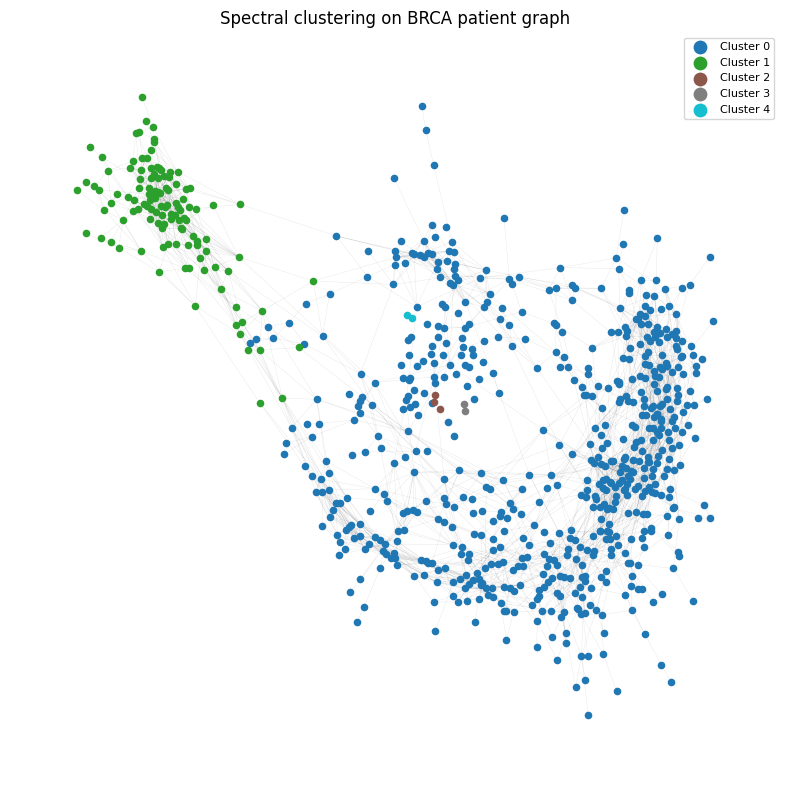

In [36]:
import matplotlib.pyplot as plt

# Unique spectral clusters
unique_clusters = np.unique(labels_spec)
n_clusters = unique_clusters.size
# Layout for the patient graph
pos = nx.spring_layout(G_pat, seed=0)
# Color map for clusters
cmap = plt.cm.get_cmap("tab10", n_clusters)
plt.figure(figsize=(8, 8))
for i, c in enumerate(unique_clusters):
    # nodes in this cluster
    nodes_c = [node for node, lab in zip(patients_order, labels_spec) if lab == c]
    nx.draw_networkx_nodes(
        G_pat,
        pos,
        nodelist=nodes_c,
        node_size=20,
        node_color=[cmap(i)],
        label=f"Cluster {c}",
    )

nx.draw_networkx_edges(G_pat, pos, alpha=0.1, width=0.3)
plt.axis("off")
plt.title("Spectral clustering on BRCA patient graph")
plt.legend(markerscale=2, fontsize=8, loc="best")
plt.tight_layout()
plt.show()


### Step 13: Visualize spectral clusters in PCA space

Plot patients in 2D PCA space colored by spectral cluster to see if clusters are geometrically coherent.

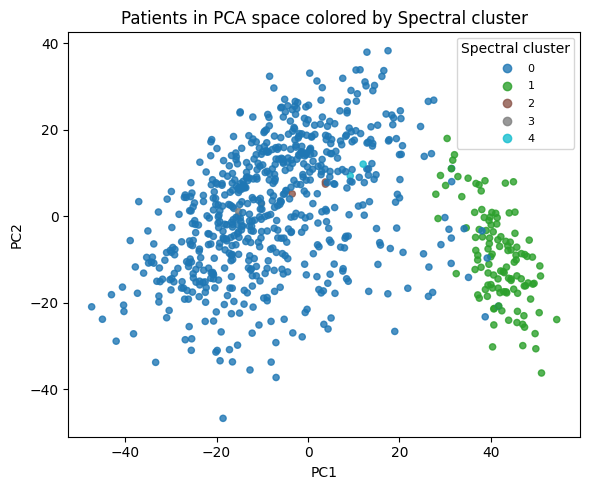

In [37]:
unique_clusters = np.unique(labels_spec)

plt.figure(figsize=(6, 5))

scatter = plt.scatter(
    emb_pat[:, 0],
    emb_pat[:, 1], 
    c=labels_spec,
    s=20,
    alpha=0.8,
    cmap="tab10",
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Patients in PCA space colored by Spectral cluster")
handles, labels = scatter.legend_elements(prop="colors")
plt.legend(handles, labels, title="Spectral cluster", fontsize=8)

plt.tight_layout()
plt.show()
